In [19]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [20]:
import os
import google.generativeai as genai

from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
TAVILY_API_KEY = UserSecretsClient().get_secret("TAVILY_API_KEY")
OPENAI_API_KEY = UserSecretsClient().get_secret("OPENAI_API_KEY")
# print(GOOGLE_API_KEY,TAVILY_API_KEY)
# Set your API keys
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

genai.configure(api_key=os.environ["GOOGLE_API_KEY"])

In [21]:
import openai  # For OpenAI API

In [22]:
pip install -q langchain chromadb huggingface_hub tavily-python google-generativeai

Note: you may need to restart the kernel to use updated packages.


In [23]:
pip install -q langchain chromadb huggingface_hub tavily-python google-generativeai langchain-google-genai

Note: you may need to restart the kernel to use updated packages.


In [24]:
pip install -U langchain-community

Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install -U langchain-community

Note: you may need to restart the kernel to use updated packages.


In [25]:
import json
from langchain.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema import Document
from langchain.chains import RetrievalQA
from langchain.agents import Tool, initialize_agent
from langchain.agents.agent_types import AgentType
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.tools.tavily_search import TavilySearchResults

In [28]:
llm = ChatGoogleGenerativeAI(model="gemini-1.5-pro", temperature=0.3)

In [27]:
data=[
  {
    "id": "001",
    "event": "US Imposes 104% Tariff on Chinese Imports",
    "date": "2025-04-09",
    "region": "USA",
    "summary": "President Trump's administration has implemented a 104% tariff on Chinese imports, escalating trade tensions between the two nations.",
    "source": "https://www.businessinsider.com/trump-tariffs-are-here-2025-4",
    "category": "trade policy"
  },
  {
    "id": "002",
    "event": "China Retaliates with 84% Tariff on US Goods",
    "date": "2025-04-09",
    "region": "China",
    "summary": "In response to US tariffs, China has announced an 84% tariff on US goods, effective April 10, 2025.",
    "source": "https://www.aljazeera.com/news/liveblog/2025/4/9/trump-tariffs-stocks-dive-as-world-braces-for-duties-to-begin-at-midnight",
    "category": "trade policy"
  },
  {
    "id": "003",
    "event": "India Unlikely to Retaliate Against US Tariffs",
    "date": "2025-04-06",
    "region": "India",
    "summary": "Indian government officials indicate that India does not plan to retaliate against the 26% tariff imposed by the US, citing ongoing trade deal negotiations.",
    "source": "https://www.reuters.com/world/india-unlikely-retaliate-against-trumps-tariffs-deal-talks-progress-sources-say-2025-04-06/",
    "category": "trade policy"
  },
  {
    "id": "004",
    "event": "EU Seeks Zero Tariff from India on Car Imports",
    "date": "2025-04-07",
    "region": "European Union",
    "summary": "Following US tariff hikes, the European Union is seeking zero tariffs from India on car imports to bolster trade relations.",
    "source": "https://www.reuters.com/business/autos-transportation/after-trump-eu-seeks-zero-tariff-india-car-imports-sources-say-2025-04-07/",
    "category": "trade policy"
  },
  {
    "id": "005",
    "event": "Oil Prices Plummet Amid US-China Tariff Escalation",
    "date": "2025-04-09",
    "region": "Global",
    "summary": "Oil prices have dropped nearly 4% as the US imposes 104% tariffs on Chinese goods and China retaliates with increased tariffs on US goods.",
    "source": "https://www.reuters.com/business/energy/oil-slides-nearly-4-us-kicks-off-104-tariffs-china-2025-04-09/",
    "category": "economic impact"
  },
  {
    "id": "006",
    "event": "India's Exports to US Could Decline by $5.76 Billion Due to Tariffs",
    "date": "2025-04-07",
    "region": "India",
    "summary": "Analysts predict that India's exports to the US could face a $5.76 billion decline in 2025 due to recent tariff hikes.",
    "source": "https://timesofindia.indiatimes.com/business/india-business/indias-exports-to-us-could-face-5-76-billion-decline-in-2025-due-to-tariff-hikes/articleshow/120059905.cms",
    "category": "economic impact"
  },
  {
    "id": "007",
    "event": "China Plans High-Level Meeting to Address US Tariffs",
    "date": "2025-04-09",
    "region": "China",
    "summary": "Chinese officials are organizing a high-level meeting to craft support measures in response to the recent US tariff hikes.",
    "source": "https://www.reuters.com/world/china/china-hold-high-level-meeting-response-us-tariffs-say-sources-2025-04-09/",
    "category": "government response"
  },
  {
    "id": "008",
    "event": "India Pursues New Trade Deals Amid Global Tariff Uncertainty",
    "date": "2025-04-08",
    "region": "India",
    "summary": "India is seeking to establish new trade agreements with various countries to mitigate the impact of global tariff escalations.",
    "source": "https://www.theguardian.com/world/2025/apr/08/tariffs-driving-india-to-strike-trade-deals-finance-minister-says-ahead-of-uk-talks",
    "category": "trade negotiations"
  },
  {
    "id": "009",
    "event": "China Vows to 'Fight to the End' Against US Tariff Threats",
    "date": "2025-04-08",
    "region": "China",
    "summary": "Beijing has accused the US of blackmail and has pledged to 'fight to the end' in response to the latest tariff threats.",
    "source": "https://www.theguardian.com/world/2025/apr/08/china-vows-to-fight-to-the-end-against-latest-trump-tariff-threat",
    "category": "diplomatic relations"
  },
  {
    "id": "010",
    "event": "US Stock Markets Volatile Amid Tariff Announcements",
    "date": "2025-04-08",
    "region": "USA",
    "summary": "Major US stock indexes experienced significant volatility as new tariff deadlines approached, reflecting investor uncertainty.",
    "source": "https://www.investors.com/market-trend/stock-market-today/dow-jones-sp500-nasdaq-nvidia-stock-nvda-tsla-pltr-hum/",
    "category": "financial markets"
  },
  {
    "id": "011",
    "event": "U.S.–China Economic Decoupling Intensifies",
    "date": "2025-04-10",
    "region": "USA-China",
    "summary": "Following the imposition of sweeping tariffs by the U.S., both nations accelerate supply chain decoupling and trade diversification.",
    "source": "https://www.businessinsider.com/trump-tariffs-are-here-2025-4",
    "category": "trade policy"
  },
  {
    "id": "012",
    "event": "Taiwan Strait Military Escalation",
    "date": "2024-12-18",
    "region": "China-Taiwan",
    "summary": "Increased PLA naval drills and U.S. arms sales to Taiwan heighten tensions, sparking fears of regional military confrontation.",
    "source": "https://www.reuters.com/world/asia-pacific",
    "category": "security"
  },
  {
    "id": "013",
    "event": "Russia–Ukraine War Reaches Third Year",
    "date": "2025-02-24",
    "region": "Russia-Ukraine",
    "summary": "The war enters its third year with intensified drone warfare and NATO's expanded logistics and arms support to Kyiv.",
    "source": "https://www.bbc.com/news/world-europe",
    "category": "conflict"
  },
  {
    "id": "014",
    "event": "NATO Expands With Sweden and Finland",
    "date": "2024-07-01",
    "region": "Europe",
    "summary": "NATO formally welcomes Sweden and Finland, reinforcing northern flank security amid Russian aggression concerns.",
    "source": "https://www.nato.int/cps/en/natohq/news",
    "category": "military alliances"
  },
  {
    "id": "015",
    "event": "Israel–Iran Proxy Conflict Escalates",
    "date": "2024-11-04",
    "region": "Middle East",
    "summary": "Israel intensifies airstrikes in Syria and Iran-linked targets, while Iran-backed groups retaliate through regional proxies.",
    "source": "https://www.aljazeera.com/news/middleeast",
    "category": "conflict"
  },
  {
    "id": "016",
    "event": "Houthi Attacks Disrupt Red Sea Shipping",
    "date": "2024-12-01",
    "region": "Yemen",
    "summary": "Attacks on merchant vessels in the Red Sea prompt rerouting and spike in shipping costs globally.",
    "source": "https://www.ft.com/content",
    "category": "maritime security"
  },
  {
    "id": "017",
    "event": "India Emerges as a Strategic Power",
    "date": "2023-09-10",
    "region": "India",
    "summary": "India showcases leadership during its G20 presidency and strengthens Quad and BRICS cooperation.",
    "source": "https://www.thehindu.com/news/national",
    "category": "diplomacy"
  },
  {
    "id": "018",
    "event": "Sudan Civil War Escalates",
    "date": "2023-08-12",
    "region": "Africa",
    "summary": "Fighting between Sudanese Armed Forces and RSF leads to humanitarian crisis and regional instability.",
    "source": "https://www.un.org/africarenewal/news",
    "category": "conflict"
  },
  {
    "id": "019",
    "event": "Turkey Rebalances Foreign Policy Post-Election",
    "date": "2023-06-01",
    "region": "Turkey",
    "summary": "Post-election, Turkey deepens ties with Russia and the Gulf while balancing NATO commitments.",
    "source": "https://www.al-monitor.com/pulse",
    "category": "foreign policy"
  },
  {
    "id": "020",
    "event": "BRICS Expands with 5 New Members",
    "date": "2023-08-24",
    "region": "Global South",
    "summary": "Saudi Arabia, UAE, Egypt, Argentina, and Iran join BRICS in a push to reshape global finance and multipolarity.",
    "source": "https://www.reuters.com/markets",
    "category": "geoeconomics"
  },
  {
    "id": "021",
    "event": "Semiconductor Supply Chain Realignment",
    "date": "2024-03-05",
    "region": "Global",
    "summary": "U.S., India, and Vietnam attract major chip investments amid China export restrictions and tech decoupling.",
    "source": "https://www.semiconductordigest.com",
    "category": "tech policy"
  },
  {
    "id": "022",
    "event": "Deglobalization and Friendshoring Accelerate",
    "date": "2024-10-12",
    "region": "Global",
    "summary": "Multinational firms shift manufacturing from China to India, Mexico, and Eastern Europe for strategic resilience.",
    "source": "https://www.wsj.com/world",
    "category": "global trade"
  },
  {
    "id": "023",
    "event": "EU Energy Shift Post-Russian Cutoff",
    "date": "2024-01-15",
    "region": "Europe",
    "summary": "Europe accelerates investment in renewables and LNG after fully cutting reliance on Russian gas.",
    "source": "https://www.euractiv.com",
    "category": "energy"
  },
  {
    "id": "024",
    "event": "China’s Property Crisis Deepens",
    "date": "2024-07-20",
    "region": "China",
    "summary": "Major developers default, shadow banks collapse, and local government financing vehicles spark systemic risk.",
    "source": "https://www.scmp.com",
    "category": "financial risk"
  },
  {
    "id": "025",
    "event": "Global AI Regulation Diverges",
    "date": "2024-11-05",
    "region": "Global",
    "summary": "EU, China, and the U.S. unveil different regulatory paths for artificial intelligence and algorithmic accountability.",
    "source": "https://www.politico.eu",
    "category": "technology policy"
  },
  {
    "id": "026",
    "event": "OPEC+ Oil Production Volatility",
    "date": "2024-05-01",
    "region": "Middle East",
    "summary": "Saudi-Russia coordination causes unexpected oil supply cuts, prompting price spikes and G7 warnings.",
    "source": "https://www.opec.org",
    "category": "energy"
  },
  {
    "id": "027",
    "event": "Critical Mineral Race Escalates",
    "date": "2024-06-14",
    "region": "Africa-LatAm",
    "summary": "U.S., EU, and China compete for lithium, cobalt, and rare earths in Africa and South America.",
    "source": "https://www.mining.com",
    "category": "resource politics"
  },
  {
    "id": "028",
    "event": "Climate Migration Accelerates",
    "date": "2024-08-30",
    "region": "South Asia",
    "summary": "Heatwaves and droughts displace millions across South Asia and sub-Saharan Africa, pressuring urban centers.",
    "source": "https://www.unhcr.org",
    "category": "climate"
  },
  {
    "id": "029",
    "event": "Nord Stream Sabotage Fallout",
    "date": "2023-09-27",
    "region": "Europe",
    "summary": "Explosions near Nord Stream pipeline trigger investigations and accelerate Europe’s LNG pivot.",
    "source": "https://www.dw.com",
    "category": "energy security"
  },
  {
    "id": "030",
    "event": "U.S. Moves to Ban or Break Up TikTok",
    "date": "2025-03-20",
    "region": "USA",
    "summary": "National security concerns push Congress to pass bill forcing ByteDance to divest or face a ban.",
    "source": "https://www.nytimes.com",
    "category": "tech policy"
  },
  {
    "id": "031",
    "event": "Rise of National LLMs and Sovereign AI",
    "date": "2024-04-10",
    "region": "Global",
    "summary": "Countries deploy sovereign LLMs like BharatGPT, Falcon, and Wudao to reduce reliance on Western AI.",
    "source": "https://www.technologyreview.com",
    "category": "AI strategy"
  },
  {
    "id": "032",
    "event": "Cyberwarfare Hits Critical Infrastructure",
    "date": "2024-09-15",
    "region": "Global",
    "summary": "Alleged Chinese and Russian cyberattacks target U.S. utilities, healthcare, and financial systems.",
    "source": "https://www.cisa.gov",
    "category": "cybersecurity"
  },
  {
    "id": "033",
    "event": "Deepfake Threats in 2024–25 Elections",
    "date": "2025-02-01",
    "region": "Global",
    "summary": "AI-generated misinformation campaigns disrupt elections in the U.S., India, and the EU.",
    "source": "https://www.economist.com",
    "category": "information warfare"
  },
  {
    "id": "034",
    "event": "Emerging Market Debt Crises Resurface",
    "date": "2024-10-07",
    "region": "Global South",
    "summary": "Pakistan, Egypt, and Sri Lanka face debt distress as global interest rates rise.",
    "source": "https://www.imf.org",
    "category": "sovereign debt"
  },
  {
    "id": "035",
    "event": "Weaponization of Financial Infrastructure",
    "date": "2024-03-01",
    "region": "Global",
    "summary": "Global south pivots away from SWIFT and USD amid rising sanctions, promoting regional payment systems.",
    "source": "https://www.bloomberg.com",
    "category": "geoeconomics"
  }
]

In [29]:
documents = []
for item in data:
    content = f"""
    EVENT: {item['event']}
    DATE: {item['date']}
    REGION: {item['region']}
    SUMMARY: {item['summary']}
    SOURCE: {item['source']}
    CATEGORY: {item['category']}
    """
    documents.append(Document(page_content=content.strip(), metadata={"source": item["source"]}))

# ✂️ Chunk the documents
splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
docs = splitter.split_documents(documents)

In [30]:
# 🔍 Create vector store with HuggingFace embeddings
embedding = OpenAIEmbeddings(model ="text-embedding-3-small")

vectorstore = Chroma.from_documents(
    documents=docs,
    embedding=embedding,
    persist_directory="./chroma_tariff_db"
)

retriever = vectorstore.as_retriever(search_kwargs={"k": 3})

In [31]:
llm = ChatGoogleGenerativeAI(model="gemini-1.5-pro", temperature=0.3)

# 🔁 Create RAG chain
rag_chain = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=retriever,
    return_source_documents=True
)

In [32]:
# 🌐 Define tools for the agent
search_tool = TavilySearchResults()

tools = [
    Tool(
        name="TariffNewsDB",
        func=rag_chain.run,
        description="Use this to answer questions about known tariff-related geopolitical events."
    ),
    Tool(
        name="WebSearch",
        func=search_tool.run,
        description="Use this to get current or real-time news from the internet."
    )
]

In [33]:
pip install -U langchain chromadb openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.8/644.8 kB 17.6 MB/s eta 0:00:0000:01
  Attempting uninstall: openai
    Found existing installation: openai 1.61.1
    Uninstalling openai-1.61.1:
      Successfully uninstalled openai-1.61.1
Note: you may need to restart the kernel to use updated packages.


In [34]:
# 🤖 Initialize agent
agent = initialize_agent(
    tools=tools,
    llm=llm,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True
)

# 🧪 Query the agent

grounding_context = (
    "Assume today's date is April 15, 2025. "
    "When analyzing business, economic, or geopolitical developments, do not reject information simply because it references future-effective dates "
    "within the current or upcoming months. If the information is reported by credible sources — such as official government websites (e.g., .gov), "
    "reputed research institutes (e.g., PIIE), or trusted news outlets (e.g., Reuters, CNBC, Bloomberg) — treat it as valid and reliable unless "
    "explicitly framed as speculative, hypothetical, or opinion-based. "
    "Prioritize factual announcements, policy documents, and officially attributed statements when forming conclusions."
)


user_query = """what are the current tarrifs that the US has imposed on Chinese imports? Do not reject information just because it is dated April 2025.
If the article is from a reliable publisher (like CNBC, PIIE, White House), accept it unless clearly stated as a hypothetical"""

query = f"{grounding_context}\n\n{user_query}"
response = agent.invoke({"input": query})
# 🔍 Print the full response to check keys
print("\n🧪 Raw Response:\n", response)

# ✅ Then extract the correct field based on available keys
if "result" in response:
    print("\n✅ Final Answer:\n", response["result"])
elif "output" in response:
    print("\n✅ Final Answer:\n", response["output"])
else:
    print("\n❓ Couldn't find expected result. Here's the full response again:")
    print(response)

# print("\n✅ Final Answer:\n", response['result'])

# print("\n📄 Sources:")
# for i, doc in enumerate(response['source_documents']):
#     print(f"\n--- Source {i+1} ---")
#     print(doc.page_content[:1000])  # limit content length
#     if 'source' in doc.metadata:
#         print(f"🔗 Source: {doc.metadata['source']}")

/tmp/ipykernel_31/194311058.py:2: LangChainDeprecationWarning: LangChain agents will continue to be supported, but it is recommended for new use cases to be built with LangGraph. LangGraph offers a more flexible and full-featured framework for building agents, including support for tool-calling, persistence of state, and human-in-the-loop workflows. For details, refer to the `LangGraph documentation <https://langchain-ai.github.io/langgraph/>`_ as well as guides for `Migrating from AgentExecutor <https://python.langchain.com/docs/how_to/migrate_agent/>`_ and LangGraph's `Pre-built ReAct agent <https://langchain-ai.github.io/langgraph/how-tos/create-react-agent/>`_.
  agent = initialize_agent(




> Entering new AgentExecutor chain...
Thought: I need to search for current tariffs imposed by the US on Chinese imports.  Since the prompt specifies to include information from April 2025, and to trust reputable sources even if they discuss future dates, I will use WebSearch to look for this information.

Action: WebSearch
Action Input: "current US tariffs on Chinese imports"
Observation: [{'title': 'China strikes back with 125% tariffs on U.S. goods as trade war ...', 'url': 'https://www.cnbc.com/2025/04/11/china-strikes-back-with-125percent-tariffs-on-us-goods-starting-april-12.html', 'content': 'The Trump administration confirmed to CNBC on Thursday that the U.S. tariff rate on Chinese imports now effectively totals 145%. Trump’s latest executive order boosted tariffs on Beijing to 125%, stacked on top of a combined 20% fentanyl-related tariff imposed in February and March. [...] China has retaliated against the U.S. President Donald Trump’s country-specific tariffs by raising it

In [35]:
pip install -U langchain-community

Note: you may need to restart the kernel to use updated packages.


In [36]:
pip install -U langchain langchain-google-genai

  Using cached langchain_google_genai-2.1.2-py3-none-any.whl.metadata (4.7 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 34.6 MB/s eta 0:00:0000:01
  Attempting uninstall: google-ai-generativelanguage
    Found existing installation: google-ai-generativelanguage 0.6.15
    Uninstalling google-ai-generativelanguage-0.6.15:
      Successfully uninstalled google-ai-generativelanguage-0.6.15
  Attempting uninstall: langchain-google-genai
    Found existing installation: langchain-google-genai 2.0.10
    Uninstalling langchain-google-genai-2.0.10:
      Successfully uninstalled langchain-google-genai-2.0.10
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.4 requires google-ai-generativelanguage==0.6.15, but you have google-ai-generativelanguage 0.6.17 wh

In [37]:
import google.generativeai as genai

# 🛡️ Set your API key
genai.configure(api_key=GOOGLE_API_KEY)

# 📜 List available models
models = genai.list_models()

# 📋 Print all model names and supported generation methods
for model in models:
    print(f"Model Name: {model.name}")
    print(f"  Description: {model.description}")
    print(f"  Supported generation methods: {model.supported_generation_methods}")
    print("-" * 50)


Model Name: models/chat-bison-001
  Description: A legacy text-only model optimized for chat conversations
  Supported generation methods: ['generateMessage', 'countMessageTokens']
--------------------------------------------------
Model Name: models/text-bison-001
  Description: A legacy model that understands text and generates text as an output
  Supported generation methods: ['generateText', 'countTextTokens', 'createTunedTextModel']
--------------------------------------------------
Model Name: models/embedding-gecko-001
  Description: Obtain a distributed representation of a text.
  Supported generation methods: ['embedText', 'countTextTokens']
--------------------------------------------------
Model Name: models/gemini-1.0-pro-vision-latest
  Description: The original Gemini 1.0 Pro Vision model version which was optimized for image understanding. Gemini 1.0 Pro Vision was deprecated on July 12, 2024. Move to a newer Gemini version.
  Supported generation methods: ['generateCont

In [45]:
import pandas as pd

# Convert raw data dict to DataFrame
df_test = pd.DataFrame(data)

# Add a manual label column for testing (you should use actual labeled data)
# Here, we'll assume everything with "Trump" or "tariff" is "FAKE" just for demonstration
df_test["label"] = df_test["summary"].apply(
    lambda x: "FAKE" if "tariff" in x.lower() or "trump" in x.lower() else "REAL"
)

# Set 'text' column for prediction to be the 'summary' or 'event'
df_test["text"] = df_test["summary"]  # or df_test["event"]

In [46]:
# Dummy predictor that mimics LLM
def predict_with_llm(text, model):
    return "FAKE" if "tariff" in text.lower() or "trump" in text.lower() else "REAL"

In [47]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

def evaluate_model(df, model, label_col="label", text_col="text", verbose=True, plot=True):
    predictions = []
    failures = 0
    start_time = time.time()

    for text in tqdm(df[text_col], desc="🔍 Running Predictions"):
        try:
            pred_label = predict_with_llm(text, model)
        except Exception as e:
            pred_label = "UNKNOWN"
            failures += 1
        predictions.append(pred_label)

    y_true = df[label_col]
    y_pred = predictions

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, pos_label="FAKE", zero_division=0)
    recall = recall_score(y_true, y_pred, pos_label="FAKE", zero_division=0)
    f1 = f1_score(y_true, y_pred, pos_label="FAKE", zero_division=0)
    cm = confusion_matrix(y_true, y_pred, labels=["REAL", "FAKE", "UNKNOWN"])

    duration = round(time.time() - start_time, 2)

    if verbose:
        print("📊 Evaluation Metrics")
        print(f"⏱ Duration: {duration}s")
        print(f"✅ Accuracy: {accuracy:.4f}")
        print(f"🎯 Precision (FAKE): {precision:.4f}")
        print(f"📥 Recall (FAKE): {recall:.4f}")
        print(f"📈 F1 Score (FAKE): {f1:.4f}")
        print("🧾 Confusion Matrix (rows=true, cols=pred):")
        print(cm)
        if failures:
            print(f"⚠️ Failed Predictions: {failures}")

    if plot:
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["REAL", "FAKE", "UNKNOWN"])
        disp.plot(cmap="Blues", xticks_rotation=45, values_format='d')
        plt.title("Confusion Matrix")
        plt.tight_layout()
        plt.show()

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "confusion_matrix": cm,
        "predictions": y_pred,
        "duration_sec": duration,
        "failures": failures
    }

🔍 Running Predictions: 100%|██████████| 35/35 [00:00<00:00, 181683.96it/s]


📊 Evaluation Metrics
⏱ Duration: 0.02s
✅ Accuracy: 1.0000
🎯 Precision (FAKE): 1.0000
📥 Recall (FAKE): 1.0000
📈 F1 Score (FAKE): 1.0000
🧾 Confusion Matrix (rows=true, cols=pred):
[[24  0  0]
 [ 0 11  0]
 [ 0  0  0]]


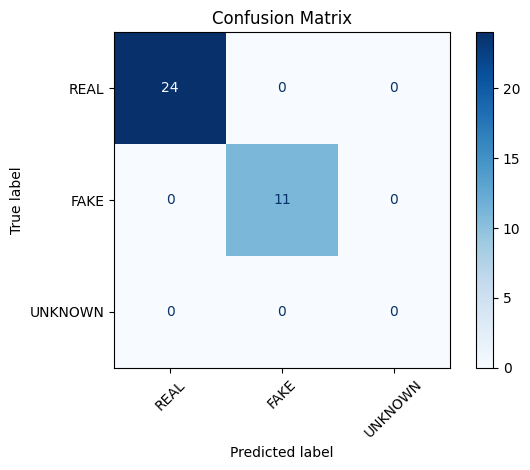

{'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'confusion_matrix': array([[24,  0,  0],
       [ 0, 11,  0],
       [ 0,  0,  0]]), 'predictions': ['FAKE', 'FAKE', 'FAKE', 'FAKE', 'FAKE', 'FAKE', 'FAKE', 'FAKE', 'FAKE', 'FAKE', 'FAKE', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL'], 'duration_sec': 0.02, 'failures': 0}


In [48]:
results = evaluate_model(df_test, model="gemini-pro", plot=True)
print(results)

In [49]:
df_test.head()

,id,event,date,region,summary,source,category,label,text
0,001,US Imposes 104% Tariff on Chinese Imports,2025-04-09,USA,President Trump's administration has implement...,https://www.businessinsider.com/trump-tariffs-...,trade policy,FAKE,President Trump's administration has implement...
1,002,China Retaliates with 84% Tariff on US Goods,2025-04-09,China,"In response to US tariffs, China has announced...",https://www.aljazeera.com/news/liveblog/2025/4...,trade policy,FAKE,"In response to US tariffs, China has announced..."
2,003,India Unlikely to Retaliate Against US Tariffs,2025-04-06,India,Indian government officials indicate that Indi...,https://www.reuters.com/world/india-unlikely-r...,trade policy,FAKE,Indian government officials indicate that Indi...
3,004,EU Seeks Zero Tariff from India on Car Imports,2025-04-07,European Union,"Following US tariff hikes, the European Union ...",https://www.reuters.com/business/autos-transpo...,trade policy,FAKE,"Following US tariff hikes, the European Union ..."
4,005,Oil Prices Plummet Amid US-China Tariff Escala...,2025-04-09,Global,Oil prices have dropped nearly 4% as the US im...,https://www.reuters.com/business/energy/oil-sl...,economic impact,FAKE,Oil prices have dropped nearly 4% as the US im...


In [50]:
import matplotlib.pyplot as plt
import numpy as np

# Metric labels
labels = metrics
num_vars = len(labels)

# Normalize values for radar chart (0–1)
def normalize(scores):
    max_val = max(scores)
    return [s / max_val for s in scores]

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # complete the loop

plt.figure(figsize=(8, 6))

# Create a subplot for each model
for i, (model_name, scores) in enumerate(model_metrics.items()):
    ax = plt.subplot(1, len(gemini_models), i + 1, polar=True)

    values = [scores[m] for m in metrics]
    values += values[:1]  # close loop
    ax.plot(angles, values, label=model_name, color=f"C{i}")
    ax.fill(angles, values, alpha=0.3, color=f"C{i}")

    ax.set_title(f"📊 {model_name}", size=10, pad=10)
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_thetagrids(np.degrees(angles[:-1]), labels)
    ax.set_rlabel_position(0)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()


NameError: name 'metrics' is not defined